<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning/blob/main/14_timeseries/1_timeseries_theorie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

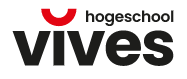<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# **Forecasting: Theorie**

Als we data hebben die tijdsafhankelijk zijn, zogenaamde **tijdreeksen** (time series in het Engels), dan zijn we meestal geïnteresseerd in de evolutie van deze data in de tijd zodat we voorspellingen kunnen doen in de toekomst. Dit noemen we **forecasting**. Als je een voorspelling wil kunnen maken, moet je een **model** kunnen opstellen voor de data. In deze notebook zullen we er een aantal bespreken. We maken hierbij onderscheid tussen voorspellingen adhv data in het verleden en voorspellingen adhv een model.

De methoden die we hier gaan bespreken, geven inzicht in de eigenschappen en de problematiek van forecasting. In het vak "Big Data & Data Science" wordt dieper ingegaan op het analyseren van tijdreeksen. Deze notebook is ook bedoeld als introductie op het hoofdstuk over "Deep Learning for Time Series (2nd edition)" uit het handboek "Deep Learning with Python" van François Chollet (2021). De resultaten van de methoden die we hier bespreken kunnen immers als **baseline** dienen voor een deep learning model. D.w.z. dat het resultaat van ons neuraal netwerk beter moet zijn dan deze baseline!

## 1. Het voorbeeld

Om de technieken duidelijk te maken, zullen we werken met een eenvoudige dataset. Het gaat om de fictieve opbrengsten van een fictieve firma voor ieder kwartaal, gedurende 5 jaar:

In [ ]:
ts = [20, 100, 175, 13, 37, 136, 245, 26, 75, 155, 326, 48, 92, 202, 384, 82, 176, 282, 445, 181]

Laten we die tijdreeks eens visualiseren adhv een plot:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

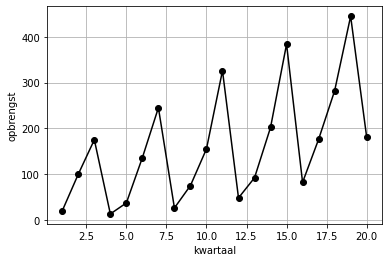

In [ ]:
kwartaal = np.arange(1, len(ts) + 1)
plt.plot(kwartaal, ts, 'ko-');
plt.grid();
plt.xlabel('kwartaal');
plt.ylabel('opbrengst');

Hier zit duidelijk een regelmaat in. De opbrengsten tonen ieder jaar hetzelfde patroon en ze
stijgen ook met de tijd. In wat volgt gaan we een aantal modellen opstellen die
proberen om een voorspelling te maken. Aangezien sommige modellen beter kunnen voorspellen
dan andere, hebben we ook een maat nodig om dat te bepalen. Dit wordt allemaal uitvoerig
besproken.

## 2. Forecasting o.b.v. het verleden

In dit deel bespreken we een paar heel eenvoudige technieken om waarden te voorspellen. Ze
geven inzicht in de eigenschappen en problematiek van forecasting. Met deze modellen kan je
ook tonen hoe je kan inschatten of een model goed of minder goed is (de betrouwbaarheid van
de voorspelling).

### 2.1. Naive forcasting

De eerste vorm van forecasting is heel eenvoudig: we gaan ervan uit dat de laatst gemeten
waarde zal blijven. In ons voorbeeld zullen we de grafiek dus aanvullen met de waarde 181 voor
de volgende kwartalen. Deze voorspellingsmethode is niet echt zinvol, maar het is wel interessant
om een aantal begrippen te tonen.

We kunnen deze manier van voorspellen ook iets wiskundiger noteren. Als er $n$ waarden zijn en
als we de gegeven waarden $x_i$ noemen (waarbij $i$ gaat van $1$ tot $n$), dan is de voorspelde waarde
$f_{n+1}$ gelijk aan:

> $f_{n+1} = x_n$

We schrijven een functie `naive_forecasting` die deze naïeve voorspellingsmethode implementeert:

In [ ]:
def naive_forecasting(ts):
    # ts is list containing time series data
    # returns forecast
    if len(ts) < 1:
        return np.nan
    return ts[-1]

We krijgen inderdaad 181 als resultaat:

In [ ]:
naive_forecasting(ts)

181

We voorspellen nu de volgende 4 kwartalen adhv onze functie. We schrijven daarvoor een nieuwe functie `forecasting`:

In [ ]:
def forecasting(ts, k, method, *args):
    # ts is list containing time series data
    # k is number of forecasts
    # method is a function to calculate the forecasts
    # args are additional arguments for method
    # returns new time series containing the k forecasts
    ts_new = ts.copy()
    for i in range(k):
        ts_new.append(method(ts_new, *args))
    return ts_new

In [ ]:
k = 4
ts2 = forecasting(ts, k, naive_forecasting)
ts2[-k:]

[181, 181, 181, 181]

En we plotten het resultaat. Daarvoor schrijven we ook eerst een generieke functie `plot_forecasting`:

In [ ]:
def plot_forecasting(ts, k):
    # ts is list containing time series data
    # k is number of forecasts
    i = np.arange(1, len(ts) + 1)
    plt.plot(i[-k-1:], ts[-k-1:], 'ro-');
    plt.plot(i[:-k], ts[:-k], 'ko-');
    plt.grid();

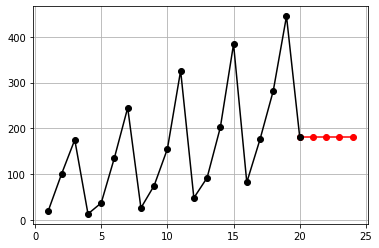

In [ ]:
plot_forecasting(ts2, k)

Dit model is op korte termijn misschien wel een redelijke voorspeller, maar op lange termijn
zal het alleen maar erger worden. Dit is een eigenschap voor alle voorspellingsmethodes: hoe
verder je in de toekomst voorspelt, hoe groter de verwachte fout. Je zou dus een soort betrouwbaarheidsinterval
kunnen opstellen dat steeds groter wordt, naarmate de tijd vordert. We zullen hier echter niet verder op in gaan.

### 2.2. Gemiddelde van alle vorige waarden

Een andere voorspellingsmethode is het gemiddelde nemen van alle voorgaande metingen.
Dit wil dus zeggen dat:

> $f_{n+1} = \frac{1}{n} \sum_{i=1}^n x_i$

De functie `average_forecasting` implementeert dit:

In [ ]:
def average_forecasting(ts):
    # ts is list containing time series data
    # returns forecast
    if len(ts) < 1:
        return np.nan
    return np.mean(ts)

In [ ]:
average_forecasting(ts)

160.0

Het gemiddelde van de reeks is dus 160. Laten we dat eens plotten voor de volgende 4 kwartalen:

In [ ]:
k = 4
ts3 = forecasting(ts, k, average_forecasting)
ts3[-k:]

[160.0, 160.0, 160.0, 160.0]

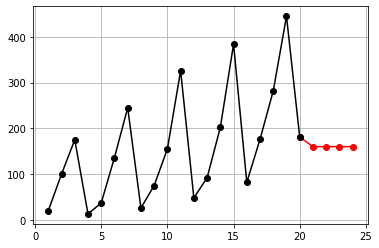

In [ ]:
plot_forecasting(ts3, k)

### 2.3. Voortschrijdend gemiddelde

Het nadeel van de vorige methode is dat deze steeds de gehele geschiedenis meeneemt in de
voorspelling. We kunnen dit veranderen door steeds het gemiddelde te nemen van de laatste $m$
metingen. Men noemt dit het voortschrijdend gemiddelde (of moving average in het Engels). Er geldt dus:

> $f_{n+1} = \frac{1}{m} \sum_{i=n-m+1}^n x_i$

In [ ]:
def moving_average_forecasting(ts, m):
    # ts is list containing time series data
    # m is number of data used to calculate the average
    # returns forecast
    n = len(ts)
    if n < m:
        return np.nan
    return np.mean(ts[n-m:n])

Als we nu de komende 4 kwartalen willen voorspellen krijgen we:

In [ ]:
k = 4  # number of forecasts
m = 4  # number of data used to calculate the moving average
ts4 = forecasting(ts, k, moving_average_forecasting, m)
ts4[-k:]

[271.0, 294.75, 297.9375, 261.171875]

Pas op! Aangezien `m = 4` worden de vorige 3 voorspellingen gebruikt om de laatste voorspelling te berekenen:

In [ ]:
np.mean(ts4[-m-1:-1])

261.171875

De plot van het resultaat:

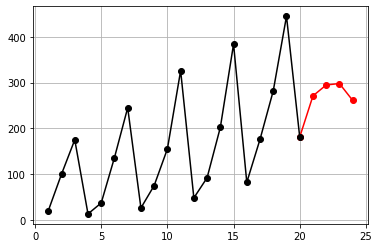

In [ ]:
plot_forecasting(ts4, m)

Het ziet er al iets beter uit dan wanneer we het gemiddelde van de volledige reeks nemen, maar we kunnen beter!

### 2.4. Lineaire combinatie

We kunnen de vorige techniek nog verbeteren door een gewogen gemiddelde te berekenen. We
gaan de volgende waarde dus voorspellen door gewichten te geven aan de vorige waarden. Deze
gewichten schatten we aan de hand van het verleden. Om een voorspelling te maken, moeten we
de gewichten vermenigvuldigen met de laatste $m$ waarden en dan alles optellen. Men noemt dit
een lineaire combinatie van de laatste $m$ waarden.
Er geldt nu dus:

> $f_{n+1} = \frac{1}{m} \sum_{i=n-m+1}^n w_ix_i$

waarbij we de gewichten $w_i$ berekenen uit het verleden. Dat kan op verschillende manieren.


De meest eenvoudige manier leert de gewichten uit de $m$ gegevens die voorafgaan aan degene
die men wil gebruiken. Als je voor die gegevens de bovenstaande formule uitschrijft, krijg je een
stelsel van $m$ vergelijkingen met $m$ onbekenden en dat kan je oplossen, bijv. m.b.v. de functie `solve` uit de `linalg` module van SciPy. We gaan niet dieper in op de wiskunde van deze techniek, maar geven hier de Python functie `get_weights` om de gewichten te berekenen:

In [ ]:
from scipy.linalg import solve

def get_weights(ts, m):
    # ts is list containing time series data
    # m is number of data used to calculate the weighted average
    # returns array with m weights
    n = len(ts)
    M = np.zeros((m, m))
    for i in range(m):
        M[i, :] = ts[(n-2*m+i):(n-m+i)]
    return solve(M, ts[n-m:n])

In ons geval vinden we volgende gewichten:

In [ ]:
m = 4
get_weights(ts, m)

array([1.0080186 , 0.13742887, 0.12600184, 0.08679208])

Eens we de gewichten $w_i$ hebben berekend, kunnen we eenvoudig het gewogen gemiddelde berekenen m.b.v. NumPy functie `inner`:

In [ ]:
def linear_combination_forecasting(ts, m):
    # ts is list containing time series data
    # m is number of data used to calculate the weighted average
    # returns forecast
    n = len(ts)
    if n < (2 * m):
        return np.nan
    w = get_weights(ts, m)
    return np.inner(w, ts[n-m:n])

Als je opeenvolgende waarden voorspelt, dan vind je deze waarden:

In [ ]:
k = 4
ts5 = forecasting(ts, k, linear_combination_forecasting, m)
ts5[-k:]

[287.94640003946205, 393.2148920003018, 543.8526167534402, 318.7714138014861]

Grafisch ziet dit er als volgt uit:

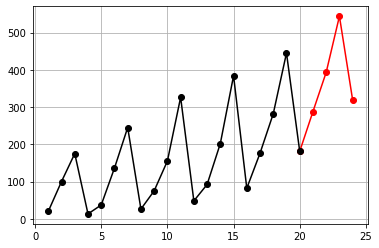

In [ ]:
plot_forecasting(ts5, k)

Dit lijkt een hele goede voorspeller. Maar het probleem is dat we niet weten hoe goed deze
voorspeller is.

## 3. Betrouwbaarheid van een model

Alvorens verder te gaan met andere voorspellingsmethoden, willen we eerst kunnen meten hoe
goed een model kan voorspellen. Maar dan hebben we data uit de toekomst nodig en die hebben
we niet. Een oplossing bestaat erin om het model toe te passen op eerdere gegevens en kijken
hoe goed het de vorige gegevens had kunnen voorspellen. Zo kunnen we de betrouwbaarheid van
het model inschatten adhv evaluatiemetrieken. We kunnen ook onze tijdreeks gaan opsplitsen in training-, validatie- en testset, net zoals we bij andere datasets doen. Alleen moeten we hier de pijl van de tijd respecteren en mogen we daarom de dataset niet shuffelen!

### 3.1. Evaluatiemetrieken

We nemen opeenvolgende kwartalen en laten ons model steeds de toekomst voorspellen. We kijken naar het verschil tussen de voorspelde waarde en de echte
waarde. De originele waarden duiden we weer aan met $x_i$.
De voorspelde waarden noemen we, naar analogie met voorgaande, $f_i$. Voor de "naive forecasting"
krijgen we dus:
> $f_i = x_{i-1}$

De waarde $f_1$ bestaat niet omdat er geen $x_0$ is (herinner je dat we vanaf 1 beginnen tellen!). Maar vanaf $f_2$ kunnen we de waarden uitrekenen. We kunnen dat als volgt berekenen in Python:

In [ ]:
f = [np.nan]
for i in range(len(ts) - 1):
    f.append(ts[i])

Wanneer we dit plotten krijgen we:

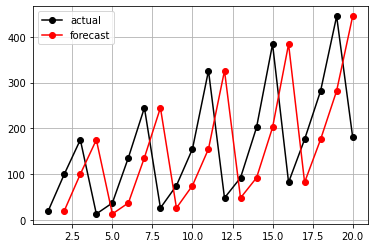

In [ ]:
plt.plot(kwartaal, ts, 'ko-',
         kwartaal, f, 'ro-');
plt.grid();
plt.legend(['actual', 'forecast']);

We kunnen dat principe implementeren in een generieke functie die elk van de geziene voorspellingsmethoden kan toepassen:

In [ ]:
def calculate_previous_forecasting(ts, method, *args):
    y = np.array(ts)
    f = []
    for i in range(len(ts)):
        f.append(method(y[:i], *args))
    return f

Laten we dat eens uittesten voor de "naive forecasting" methode:

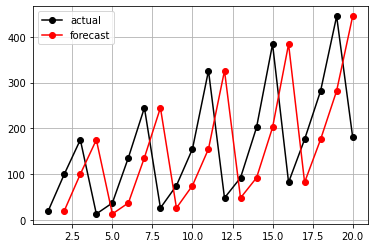

In [ ]:
f = calculate_previous_forecasting(ts, naive_forecasting)
plt.plot(kwartaal, ts, 'ko-',
         kwartaal, f, 'ro-');
plt.grid();
plt.legend(['actual', 'forecast']);

We krijgen net hetzelfde. Voor methodes die `m` data gebruiken, zoals `moving_average_forecasting` zal de rode reeks met forecasts pas beginnen vanaf datapunt met index `m+1`:

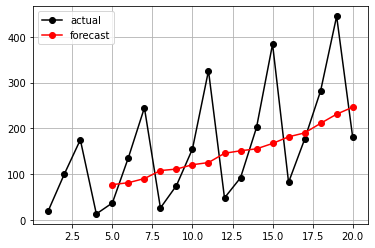

In [ ]:
m = 4
f = calculate_previous_forecasting(ts, moving_average_forecasting, m)
plt.plot(kwartaal, np.array(ts), 'ko-',
         kwartaal, np.array(f), 'ro-');
plt.grid();
plt.legend(['actual', 'forecast']);

Als we de voorspelde waarde $f_i$ aftrekken van de echte waarde $x_i$, krijgen we de fout $e_i$:

> $e_i = x_i - f_i$

Als ons model de toekomst perfect voorspelt, dan zijn alle $e_i$ gelijk aan 0. Als het model minder goed
is, dan worden de waarden van $e_i$ groter (of kleiner als ze negatief zijn). We kunnen nu de
gemiddelde fout berekenen. Dat is dan een maat voor de betrouwbaarheid van onze
voorspeller. Dit gemiddelde kan je op verschillende manieren berekenen:

- Mean Absolute Error: $MAE = \frac{1}{n} \sum_{i=1}^n |e_i|$

- Mean Squared Error: $MSE = \frac{1}{n} \sum_{i=1}^n e_i^2$

- Root Mean Squared Error: $RMSE = \sqrt(MSE) = \sqrt(\frac{1}{n} \sum_{i=1}^n e_i^2)$

Deze metrieken kennen we natuurlijk uit het vak Machine Learning. Ze zijn echter niet altijd even makkelijk te interpreteren. Dat komt omdat de fout
bij heel grote waarden ook heel groot kan worden. We zijn dikwijls meer geïnteresseerd in de fout ten
opzichte van de oorspronkelijke data en dan kunnen we de volgende metriek gebruiken:

- Mean Absolute Percentage Error: $MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|e_i|}{|x_i|}$

Het nadeel van deze maat is dat de waarden voor $x_i$ niet 0 mogen worden. Als dit het geval is, kan je enkel MAE en RMSE berekenen.

Laten we dat eens illustreren door deze metrieken toe te passen op de voorspellingen van de "naive forecasting" methode:

In [ ]:
f = calculate_previous_forecasting(ts, naive_forecasting)
x = np.array(ts)
e = np.array(f) - x
MAE = np.nanmean(np.abs(e))
MSE = np.nanmean(np.square(e))
RMSE = np.sqrt(MSE)
MAPE = np.nanmean(np.abs(e / x))

print("MAE =", MAE)
print("MSE =", MSE)
print("RMSE =", RMSE)
print("MAPE =", MAPE)

MAE = 137.42105263157896
MSE = 25185.0
RMSE = 158.6978260720669
MAPE = 2.0702566894377608


Bemerk dat we NumPy functie `nanmean` gebruiken ipv `mean` omdat onze reeks met forecasts `f` NaN-waarden bevat! De MAPE geeft aan dat de voorspelling gemiddeld 207% afwijkt van de echte waarde. Dit is dus niet zo'n goede voorspeller...

We evalueren de andere methoden en definiëren daarom eerst functies voor het berekenen van de verschillende metrieken:

In [ ]:
def MAE(ts, f):
    return np.nanmean(np.abs(np.array(ts) - np.array(f)))

def MSE(ts, f):
    return np.nanmean(np.square(np.array(ts) - np.array(f)))

def RMSE(ts, f):
    return np.sqrt(MSE(ts, f))

def MAPE(ts, f):
    return np.nanmean(np.abs((np.array(ts) - np.array(f)) / np.array(ts)))

Nu kunnen we de verschillende scores voor de verschillende methoden berekenen mbv lussen:

In [ ]:
scores = {naive_forecasting: dict(),
          average_forecasting: dict(),
          moving_average_forecasting: dict(),
          linear_combination_forecasting: dict()
          }
m = 4
for method in scores:
    try:
        f = calculate_previous_forecasting(ts, method, m)
    except:
        f = calculate_previous_forecasting(ts, method)
    for metric in [MAE, MSE, RMSE, MAPE]:
        scores[method][metric] = metric(ts, f)

De resultaten hebben we in een dictionary gestopt en die kunnen we makkelijk omzetten naar een Pandas DataFrame. Zo krijgen we een mooie overzichtstabel. We moeten wel de functies omzetten naar strings met de naam van de functies, en dat doen we m.b.v. attribuut `__name__`:

In [ ]:
import pandas as pd

df = pd.DataFrame(scores)
df.columns = [column.__name__[:-len("_forecasting")] for column in list(df.columns)]
df.index = [idx.__name__ for idx in list(df.index)]
df

,naive,average,moving_average,linear_combination
MAE,137.421053,103.004796,92.906250,28.269228
MSE,25185.000000,17110.263909,12841.726562,1075.374617
RMSE,158.697826,130.806207,113.321342,32.792905
MAPE,2.070257,1.036220,0.777070,0.174283


De forecasting mbv de lineaire combinatie geeft dus in dit geval het beste resultaat (zoals we grafisch al konden zien). De voorspelde waarde wijkt gemiddeld ongeveer 17% af van de echte waarde als we kijken naar de MAPE.

### 3.2. Opsplitsen van de dataset

We kunnen de tijdreeks ook opsplitsen in **training-, validatie- en testset**, zoals we dat bij andere datasets doen. Alleen mogen we hier de dataset niet gaan shuffelen omdat de volgorde - per definitie - van de tijdreeksdata relevant is! De regel is om de oudste data in de trainingset te stoppen en de recentste data in de testset. Dit wordt hieronder visueel voorgesteld. De pijl van de tijd moet hier dus gerespecteerd worden!

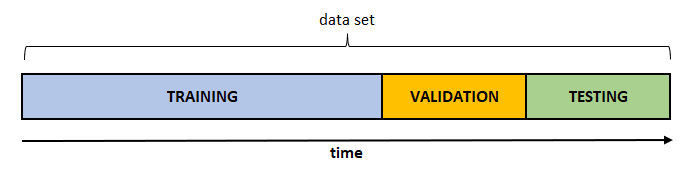

Omwille van de tijdsafhankelijkheid van de data, kunnen we geen K-fold crossvalidation toepassen. Het alternatief dat we bij tijdreeksen wel kunnen toepassen is **backtesting**. We kunnen hierbij werken met een *expanding window*, waarbij de vorige testset gewoon bij de trainingset wordt gevoegd, of met een *sliding window* waarbij de trainingset mee opschuift met de testset. Het principe hiervan wordt in onderstaande figuur geïllustreerd:

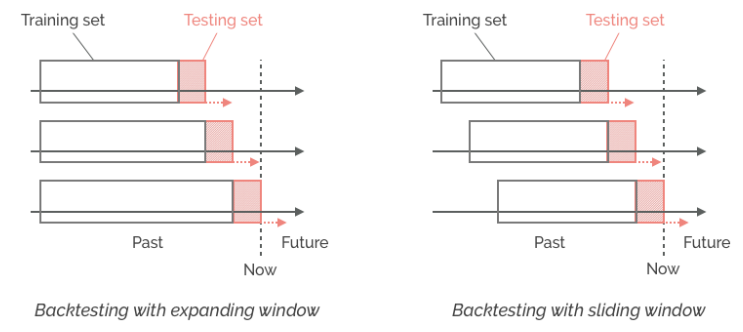

In Scikit-Learn kan je gebruik maken van de [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) klasse.


Merk op dat net als bij crossvalidatie de "testing set" hier in feite de rol van validatieset vervult, en dus kunnen we best nog een "échte" testset aan de kant zetten voor de finale evaluatie.

## 4. Een model voor de data maken

Bij de vorige voorspellingsmethodes, probeerden we de volgende waarde te voorspellen aan de
hand van het verleden. Maar dat kan ook anders. Je kan ook een model opstellen dat de
wetmatigheden in de data beschrijft. Je kan dit moedel dan gebruiken om voorspellingen te
doen, maar ook om het verleden te modelleren. Het voordeel van een model is dat het ook kan
uitleggen waarom de data zich op een bepaalde manier gedraagt. We bespreken hier 2 technieken:
trend forecasting en seasonal forecasting.

### 4.1. Trend forecasting

We kunnen een eenvoudig model opstellen voor de data waarin we een lijn zoeken die de algemene
trend weergeeft. Dit kunnen we doen met regressie. Dit kan lineaire regressie zijn, maar
natuurlijk ook polynomiale regressie. Het model dat uit de regressie komt, is eigenlijk ook een
voorspeller. We gaan ervan uit dat onze data een functie zijn van de tijd en daarom zetten we de
nummers $1$ t.e.m. $n$ op de X-as. Die symboliseren namelijk het tijdstip en zijn de onafhankelijke variabele.

We verwijzen naar het vak Machine Learning voor een uitgebreide bespreking over lineaire en polynomiale regressie. Hier gaan we ter illustratie enkelvoudige lineaire regressie en polynomiale regressie met een veeltermfunctie van graad 3 toepassen. We gebruiken hiervoor de NumPy functies `polyfit` en `polyval`.

#### Lineaire regressie

We starten dus met de enkelvoudige lineaire regressie:

In [ ]:
p = np.polyfit(kwartaal, ts, deg=1)  # lineaire regressie = graad 1!
k = 4
kwartaal_plus = np.arange(1, len(ts) + m + 1)
ts6 = np.polyval(p, kwartaal_plus)
ts6[-k:]

array([282.32105263, 293.97067669, 305.62030075, 317.26992481])

Laten we de regressielijn uitzetten op grafiek:

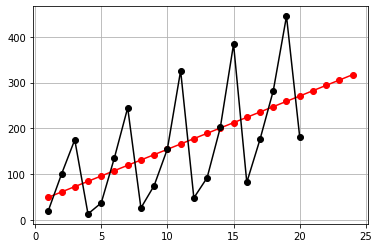

In [ ]:
plt.plot(kwartaal_plus, ts6, 'ro-');
plt.plot(kwartaal, ts, 'ko-');
plt.grid();

De RMSE is:

In [ ]:
RMSE(ts, ts6[:-k])

100.61668907443115

Bemerk dat we de RMSE (en eventueel ook de andere metrieken die we hebben gezien) ook zouden kunnen berekenen door het model steeds opnieuw op te stellen voor opeenvolgende waarden (zoals hierboven werd gedaan). We kiezen in dit document echter om het berekende model te gebruiken in het verleden omdat we niet verwachten dat dit model veel zal veranderen naarmate er meer data beschikbaar komt. Als
dit toch het geval is, moet je dus steeds een nieuw model opstellen, naarmate er meer data
beschikbaar is.

#### Polynomiale regressie

En vervolgens fitten we een derdegraads veeltermfunctie:

In [ ]:
p = np.polyfit(kwartaal, ts, deg=3)  # graad 3
k = 4
ts7 = np.polyval(p, kwartaal_plus)
ts7[-m:]

array([314.97420021, 338.33038479, 363.39909935, 390.27430003])

De plot:

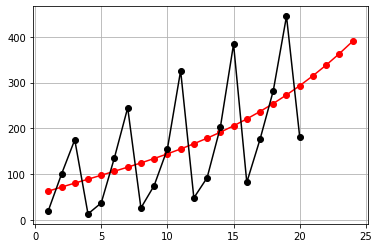

In [ ]:
plt.plot(kwartaal_plus, ts7, 'ro-');
plt.plot(kwartaal, ts, 'ko-');
plt.grid();

De RMSE:

In [ ]:
RMSE(ts, ts7[:-k])

100.1531050631349

Dit is slechts een verwaarloosbare verbetering t.o.v. de lineaire regressie. Beide regressiemodellen zijn niet zo heel goed. De voorspelde waarden volgen een rechte lijn of licht gebogen curve, terwijl de echte
waarden schommelen rond die lijn of curve. Daardoor wordt de fout ook steeds groter. Dit
model kan de variaties niet goed voorspellen en is enkel bruikbaar als de oorspronkelijke data
gelijkmatiger veranderen. Als we ook de schommelingen willen meenemen, hebben we nood aan
een ander model. Dit bespreken we hieronder.

### 4.2. Seasonal forecasting

#### Het principe

Bij seasonal forecasting gaan we ongeveer op dezelfde manier te werk als bij regressie. We zoeken
namelijk een soort formule (een model) waarmee we voorspellingen kunnen doen. We gebruiken
alleen geen lijn, maar een ander model.
Tijdsgebonden data bestaat meestal uit een aantal componenten:
- een (al dan niet lineaire) **trend** die stijgend of dalend is;
- een **seizoensgebonden** patroon dat om de zoveel metingen steeds terug komt, waarbij je "seizoen" niet te letterlijk mag opvatten, want het kan ook over de dag in de week gaan;
- een **cyclisch** patroon dat voorkomt wanneer de data stijgen en dalen volgens een frequentie die niet vast is en met een duur die gewoonlijk minstens twee jaar is, bijv. door economische omstandigheden;
- een niet regelmatige component dat we als **ruis** (Engels: noise) beschouwen die niet te voorspellen is.

Dit wordt op onderstaande figuur samengevat:

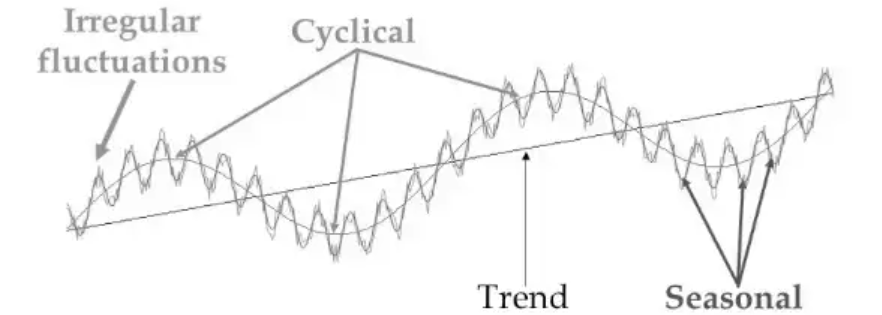

Als we gemakshalve de cycliciteit buiten beschouwing laten, kunnen we er nu van uitgaan dat een datapunt $x_i$ gelijk is aan de som van 3 componenten:

> datapunt = trend + seizoen + ruis

Of meer wiskundig:

> $x_i = T(i) + S(i) + ϵ_i$

Dit noemt men een **additief decompositiemodel**.

Maar dikwijls worden de seizoensschommelingen groter als de waarden zelf groter worden. Je kan dit
zien in het voorbeeld van de opbrengsten: als de opbrengsten groter worden, dan worden de schommelingen ook groter. In dat geval gebruik je beter het **multiplicatief decompositiemodel**. Dit ziet er als volgt uit:

> $x_i = T(i) . S(i) . ϵ_i$

We zijn het meest geïnteresseerd in de formules voor $T(i)$ en $S(i)$ aangezien $ϵ_i$ niet te voorspellen
is.

#### Het bepalen van de seizoensgrootte

Om de formules voor $T(i)$ en $S(i)$ te vinden, moeten we weten hoe groot een seizoen is (de grootte
van het wederkerend patroon). In vele gevallen is dit al bekend. In ons voorbeeld hebben we de
cijfers per kwartaal genoteerd. We verwachten dus een patroon dat zich ieder jaar, en dus iedere
4 kwartalen, herhaalt.
Als je niet weet wat de grootte van een seizoen is, dan kan je dit soms wel vinden via **autocorrelatie**. We gaan het signaal (de gemeten data) correleren met zichzelf, maar dan verplaatst in de
tijd. Als we het signaal verplaatsen over dezelfde afstand als een seizoen, dan zal de correlatie
hoger zijn.

In Python kunnen we gebruik maken van de [statsmodels](https://www.statsmodels.org/stable/index.html) module om de autocorrelaties te berekenen en te plotten. Het aantal lags `nlags` nemen we hier gelijk aan 12. D.w.z. dat we in ons voorbeeld de correlatie berekenen tussen datapunten die 0, 1, 2, 3, ..., 11 en 12 kwartalen uit elkaar liggen! De parameter `fft` (wat voor "Fast Fourier Transform" staat) zetten we op `False` om een warning te vermijden.

[ 1.          0.14841967 -0.1784992   0.04820923  0.67317336 -0.02078408
 -0.279082   -0.06217802  0.37916262 -0.09759705 -0.3030568  -0.1125053
  0.13098004]


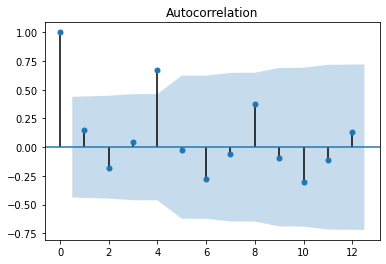

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

# print autocorrelation
print(sm.tsa.acf(ts, nlags=12, fft=False))

# plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=12)

Er is een duidelijke piek bij 0, maar dat is normaal want de waarden correleren nl. heel goed
moet zichzelf. Er is echter ook een piek voor `i = 4`. Dat wil zeggen dat het signaal, verschoven over
4 tijdseenheden, sterk lijkt op het oorspronkelijke signaal. De periode van een seizoen is dus 4.
Autocorrelatie werkt niet altijd even goed, dus zal je in veel gevallen handmatig moeten bepalen
wat de seizoensgrootte is. Gelukkig is dit in de praktijk meestal wel eenvoudig te bepalen.

#### Het bepalen van de trend

Om de waarden van $T(i)$ en $S(i)$ te vinden, zijn er verschillende technieken.
Meestal begint men met het zoeken van de component $T(i)$. Dit is de trend in de grafiek, zonder de ruis
en zonder het weerkerend patroon. We kunnen deze trend gemakkelijk vinden omdat volgende
eigenschappen gelden:

- seizoenen hebben een hogere frequentie dan de trend;
- de ruis heeft een nog hogere frequentie.

Als we dus de hoge frequenties wegfilteren, dan vinden we de waarden van de trend. Dit kunnen
we doen door het voortschrijdend gemiddelde te nemen van steeds $m$ getallen (waarbij $m$ de
seizoensgrootte is). Als je het gemiddelde neemt van $m$ getallen waarbij $m$ de grootte van een
seizoen is, dan filter je alle seizoenen en de ruis weg.

In Python kunnen we eenvoudig zelf deze bewerking uitvoeren:

In [ ]:
x = np.array(ts)
n = len(x)
T = np.nan * np.ones(n)  # padding with NaNs!
idx = np.arange(m)
T[2:-2] = [np.mean(x[idx + i]) for i in range(n - m)]
T

array([   nan,    nan,  77.  ,  81.25,  90.25, 107.75, 111.  , 120.5 ,
       125.25, 145.5 , 151.  , 155.25, 167.  , 181.5 , 190.  , 211.  ,
       231.  , 246.25,    nan,    nan])

Omdat `m = 4` hebben we dus `20 - 4 = 16` waarden (met 20 de lengte van onze tijdreeks `ts` met data). We willen dezelfde lengte voor `T` als voor onze tijdreeks `ts` en daarom voegen we vooraan en achteraan telkens 2 NaN-waarden toe.

Nu we de waarden van de trend $T(i)$ kennen, kunnen we verder gaan met het zoeken naar de seizoenale component $S(i)$. Het verschil (of het quotiënt als we de multiplicatieve vorm gebruiken) tussen het gefilterde signaal en het originele signaal levert dus een signaal waar enkel nog de oscillaties van de seizoenen en de ruis in zitten. We doen dus:

- additief: $S(i) + ϵ_i = x_i - T(i)$
- multiplicatief: $S(i) . ϵ_i = x_i / T(i)$

Wij werken volgens een multiplicatief model en dus krijgen we:

In [ ]:
SR = x / T  # SR = S * R (R staat voor ruis)
SR

array([       nan,        nan, 2.27272727, 0.16      , 0.4099723 ,
       1.26218097, 2.20720721, 0.21576763, 0.5988024 , 1.0652921 ,
       2.1589404 , 0.30917874, 0.5508982 , 1.11294766, 2.02105263,
       0.38862559, 0.76190476, 1.14517766,        nan,        nan])

#### Het bepalen van het seizoen

Uit het signaal zonder de trend (dus seizoenaal patroon plus ruis) willen we het seizoenale patroon $S(i)$ halen dat steeds weerkeert. Aangezien we de seizoensgrootte $m$ kennen, gaan we als volgt te werk: we delen het signaal
op in $m$ groepjes met punten die steeds $m$ van elkaar liggen. Dan nemen we de gemiddelde
waarde van ieder groepje. Zo vinden we $m$ waarden die een patroon vormen dat gemiddeld
voorkomt in het signaal. Dit is de component $S(i)$ die we zoeken. Je ziet dit proces hier grafisch voorgesteld:

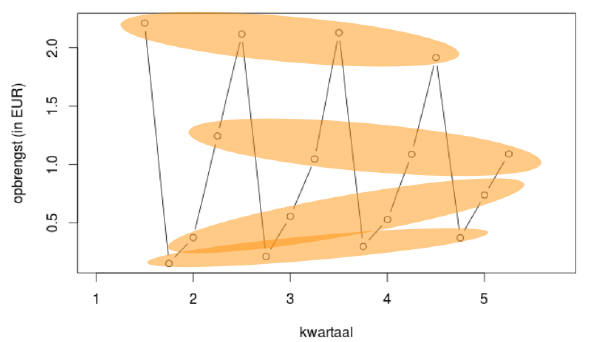

We kunnen dat eenvoudig zelf berekenen in Python:

In [ ]:
S = [np.nanmean(SR[range(i, n, m)]) for i in range(m)]
S

[0.580394414969033, 1.1463995985186783, 2.164981877216105, 0.26839299280829654]

Merk op dat we hier opnieuw `nanmean` gebruiken omdat de reeks `SR` NaN-waarden bevat!

We moeten die waarden nu nog gaan herhalen voor elk "seizoen" in de tijdreeks. We gebruiken hiervoor NumPy functie `tile`. Het aantal "seizoenen" is gelijk aan `n // m`. We krijgen dus:

In [ ]:
S = np.tile(S, n // m)
S

array([0.58039441, 1.1463996 , 2.16498188, 0.26839299, 0.58039441,
       1.1463996 , 2.16498188, 0.26839299, 0.58039441, 1.1463996 ,
       2.16498188, 0.26839299, 0.58039441, 1.1463996 , 2.16498188,
       0.26839299, 0.58039441, 1.1463996 , 2.16498188, 0.26839299])

#### Het bepalen van de ruis

Nu we ook de waarden van het seizoenale patroon hebben, kunnen we de ruis bepalen:

- additief: $ϵ_i = x_i - T(i) - S(i)$
- multiplicatief: $ϵ_i = x_i / T(i) / S(i)$

Dat is uiteraard zeer eenvoudig te berekenen in Python:

In [ ]:
R = x / T / S
R

array([       nan,        nan, 1.04976734, 0.59614075, 0.70636844,
       1.10099565, 1.01950378, 0.80392425, 1.03171633, 0.92925023,
       0.99720945, 1.1519628 , 0.94917902, 0.97082   , 0.93351942,
       1.4479722 , 1.31273621, 0.99893411,        nan,        nan])

Je kan nagaan of de waarden kloppen door alles weer te vermenigvuldigen (of op te tellen als je
additief werkt):

In [ ]:
np.all(ts[2:-2] == np.round((T * S * R)[2:-2]))  # 2:-2 om de NaNs weg te laten!

True

Alle waarden zijn dus inderdaad gelijk! Merk op dat we de NaN-waarden uit de vergelijking hebben weggelaten en dat we hebben afgerond omwille van het voorkomen van afrondingsfouten.

#### De componenten plotten

We kunnen nu alle componenten uitzetten in grafieken:

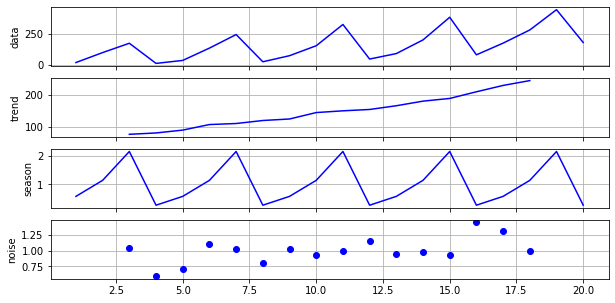

In [ ]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
ax1.plot(kwartaal, ts, 'b-');
ax1.grid()
ax1.set_ylabel('data')
ax2.plot(kwartaal, T, 'b-');
ax2.grid()
ax2.set_ylabel('trend')
ax3.plot(kwartaal, S, 'b-');
ax3.grid()
ax3.set_ylabel('season')
ax4.plot(kwartaal, R, 'bo');
ax4.set_ylabel('noise')
ax4.grid()

Omdat we volgens een multiplicatief model hebben gewerkt, is de bovenste grafiek met de data dus gelijk aan het product van de onderste 3 grafieken:

> `data = trend * season * noise`

#### Voorspellingen maken

Als we voorspellingen willen maken, dan gaan we de grafiek van de trend verder zetten en het
patroon verder herhalen. De ruis kunnen we natuurlijk niet voorspellen, dus laten we deze weg.
Om de trend verder te kunnen zetten, kunnen we een regressie uitvoeren zodat we een formule
hebben voor $T(i)$. Een lineaire regressie levert bijvoorbeeld volgende formule:

> $T(i) = a + b.i$

We passen dus een enkelvoudige lineaire regressie toe op de waarden van de trend:

In [ ]:
coef = np.polyfit(kwartaal[2:-2], T[2:-2], deg=1)
b, a = tuple(coef)
a, b

(35.58235294117651, 10.846323529411768)

Om een voorspelling te doen, gaan we het seizoenale patroon $S$ vermenigvuldigen (omdat we
multiplicatief werken) met de voorspelde trend:

In [ ]:
m = 4  # seizoensgrootte
f = (a + b * kwartaal_plus) * np.hstack((S, S[:m]))
f

array([ 26.94694452,  65.66003701, 147.48143089,  21.19436313,
        52.12752692, 115.39692076, 241.4098064 ,  32.83867206,
        77.30810931, 165.13380452, 335.3381819 ,  44.48298099,
       102.48869171, 214.87068828, 429.2665574 ,  56.12728993,
       127.66927411, 264.60757204, 523.1949329 ,  67.77159886,
       152.84985651, 314.3444558 , 617.12330841,  79.41590779])

Laten we dat eens plotten:

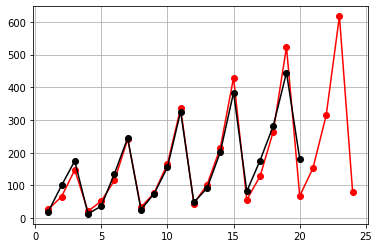

In [ ]:
plt.plot(kwartaal_plus, f, 'ro-');
plt.plot(kwartaal, ts, 'ko-');
plt.grid();

Zoals je ziet, is dit een hele goede voorspeller. We vinden volgende metrieken:

In [ ]:
print("MAE = ", MAE(ts, f[:-m]))
print("RMSE = ", RMSE(ts, f[:-m]))
print("MAPE = ", MAPE(ts, f[:-m]))

MAE =  25.005078083516697
RMSE =  37.10801140916826
MAPE =  0.21315624012259296


Deze voorspeller is (in dit geval) dus ongeveer even goed als de lineaire combinatie.

#### StatsModels

De handelingen die we hebben uitgevoerd voor het bepalen van de componenten zijn nogal veel werk. Je kan dit alles natuurlijk ook in een functie zetten, maar gelukkig kunnen we weer gebruiken maken van de `statsmodels` module!

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model="multiplicative", period=m)

We hebben dus voor het `'multiplicative'` model gekozen. De `period` is de seizoensgrootte `m`.

We kunnen nu de verschillende componenten opvragen. De `trend`:

In [ ]:
result.trend

array([    nan,     nan,  79.125,  85.75 ,  99.   , 109.375, 115.75 ,
       122.875, 135.375, 148.25 , 153.125, 161.125, 174.25 , 185.75 ,
       200.5  , 221.   , 238.625, 258.625,     nan,     nan])

Het `seasonal` patroon:

In [ ]:
result.seasonal

array([0.54611163, 1.11220357, 2.08468854, 0.25699626, 0.54611163,
       1.11220357, 2.08468854, 0.25699626, 0.54611163, 1.11220357,
       2.08468854, 0.25699626, 0.54611163, 1.11220357, 2.08468854,
       0.25699626, 0.54611163, 1.11220357, 2.08468854, 0.25699626])

De ruis, wat men ook residuals noemt:

In [ ]:
result.resid

array([       nan,        nan, 1.06092125, 0.58990546, 0.68436077,
       1.11798649, 1.01532226, 0.82334719, 1.01447505, 0.9400538 ,
       1.02124588, 1.15918165, 0.96679327, 0.9777735 , 0.91870413,
       1.44375922, 1.35056442, 0.98037972,        nan,        nan])

De waarden zijn niet dezelfde als die wij hebben berekend, maar dat is omdat men op een iets andere manier de trend berekent. Tenslotte kunnen we die componenten ook plotten:

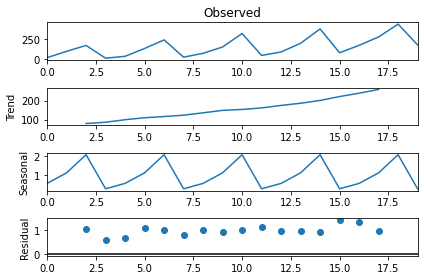

In [ ]:
fig = result.plot()

De `statsmodels` library heeft nog veel andere modellen beschikbaar voor Time Series Analysis, zoals Exponential Smoothing, ARMA, ARIMA, ... Check de `tsa` module van `statsmodels`: https://www.statsmodels.org/stable/tsa.html. Ter illustratie fitten we hier onze tijdreeks m.b.v. klasse `ARIMA`:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(ts, order=(2, 1, 4))
model = model.fit()
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -105.040
Date:                Sun, 04 Dec 2022   AIC                            224.080
Time:                        13:08:33   BIC                            230.691
Sample:                             0   HQIC                           225.199
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0019      0.125      0.015      0.988      -0.244       0.248
ar.L2         -0.9995      0.014    -69.346      0.000      -1.028      -0.971
ma.L1         -1.1957      1.171     -1.021      0.307      -3.490       1.099
ma.L2          1.8132      4.961      0.366      0.715      -7.910      11.536
ma.L3         -1.1897      6.088     -0.195      0.845     -13.122      10.742
ma.L4          0.8943      4.706      0.190      0.849      -8.329      10.118
sigma2      2012.3349   9705.749      0.207      0.836    -1.7e+04     2.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.62   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.03   Prob(JB):                         0.39
Heteroskedasticity (H):               2.41   Skew:                             0.68
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We krijgen enkele verontrustende warnings en de statistieken geven aan dat ons ARIMA model niet bijster goed is. Dat zien we ook als we de voorspellingen plotten:

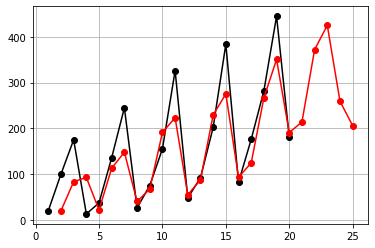

In [ ]:
plt.plot(kwartaal, ts, 'ko-')
f = model.predict(1, len(kwartaal_plus))
plt.plot(kwartaal_plus + 1, f, 'ro-');
plt.grid();

We hebben hier lukraak een ARIMA model toegepast om het gebruik van `statsmodels` te demonstreren. Maar uiteraard is het niet de bedoeling om dat op die manier te gaan doen. Laten we eens "Auto ARIMA" toepassen om te zien of dat een beter resultaat geeft!

#### Auto ARIMA

In Python is er de [`pmdarima`](https://pypi.org/project/pmdarima/) package waarmee we automatisch ARIMA modellen kunnen opstellen. D.w.z. dat de hyperparameters (semi-)automatisch worden bepaald. Het is echter niet standaard beschikbaar in Google Colab, dus we moeten het eerst installeren:

In [ ]:
!pip install pmdarima

We zien dat de package gebruik maakt van `statsmodels`. Zoals we zullen zien, wrapt het inderdaad `statsmodels` modellen.

We importeren `auto_arima`:

In [ ]:
from pmdarima import auto_arima

Als we `auto_arima` zonder meer toepassen op onze tijdreeks, dan past het in dit geval de naïeve voorspellingsmethode toe:

In [ ]:
model = auto_arima(ts)
model.predict(k)  # let op! predict geeft enkel voorspellingen in de toekomst!

array([181., 181., 181., 181.])

We zien dat het model 4 keer 181 voorspelt, het laatste datapunt in de tijdreeks. We kunnen dit oplossen door hyperparameter `m` op te geven die de seizoenaliteit in rekening brengt:

In [ ]:
model = auto_arima(ts, m=m)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   20
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 4)   Log Likelihood                 -70.185
Date:                            Sun, 04 Dec 2022   AIC                            146.371
Time:                                    13:08:40   BIC                            148.495
Sample:                                         0   HQIC                           146.348
                                             - 20                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0995      0.289     -3.807      0.000      -1.666      -0.533
ma.L2          0.6136      0.593      1.035      0.301      -0.548       1.775
sigma2       611.1755    292.099      2.092      0.036      38.671    1183.680
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.99   Prob(JB):                         0.63
Heteroskedasticity (H):               1.23   Skew:                             0.11
Prob(H) (two-sided):                  0.83   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

De voorspelde waarden van de datapunten in de trainingset vragen we op met `predict_in_sample`:

In [ ]:
yp = model.predict_in_sample()

Met `predict` kunnen we dus échte voorspellingen in de toekomst maken:

In [ ]:
f = model.predict(k)

Laten we tot slot het resultaat plotten:

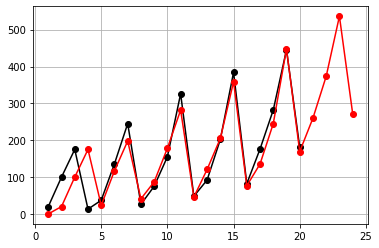

In [ ]:
plt.plot(kwartaal, ts, 'ko-')
plt.plot(kwartaal_plus, np.hstack((yp, f)), 'ro-');
plt.grid();

Dat ziet er al veel beter uit dan onze eigen poging! Zeer handig natuurlijk die `auto_arima`, hoewel we ook hebben gezien dat het blindelings toepassen ervan niet altijd een goed idee is. Hoe je wel correct dergelijke meer gevorderde statistische modellen moet toepassen ligt echter buiten de scope van deze introductie. In het vak "Big Data & Data Science" wordt dieper ingegaan op tijdreeksanalyse en zullen de belangrijkste van deze modellen uitvoerig besproken worden, waaronder ook ARIMA!

#### Prophet

In Python (en R) kan je ook gebruik maken van [Prophet](https://facebook.github.io/prophet/docs/quick_start.html). Het is een open-source library ontwikkeld door Facebook/Meta voor het toepassen van forecasting op univariate tijdreeksen. Dat zijn dus tijdreeksen met slechts 1 variabele, zoals de tijdreeks uit ons voorbeeld.

Prophet maakt gebruik van een additief model:

> $x_i = T(i) + S(i) + H(i) + ϵ_i$

De component $H(i)$ houdt rekening met vakanties (holidays), wat in ons voorbeeld niet relevant is. Dus component $H(i)$ zullen we niet in rekening brengen.

Prophet vraagt een Pandas dataframe als input met een kolom `"ds"` met `datetime` objecten, en een kolom `"y"` met de data van de tijdreeks. Aangezien onze tijdreeks over kwartalen gaat, maken we `datetime` objecten aan om de 3 maanden, startend bij 1 januari van het jaar 2010:

In [ ]:
import pandas as pd
from prophet import Prophet
from datetime import datetime

In [ ]:
ds = [datetime(2010 + (1 + i * 3) // 12, (1 + i * 3) % 12, 1) for i in range(len(ts))]
ds

[datetime.datetime(2010, 1, 1, 0, 0),
 datetime.datetime(2010, 4, 1, 0, 0),
 datetime.datetime(2010, 7, 1, 0, 0),
 datetime.datetime(2010, 10, 1, 0, 0),
 datetime.datetime(2011, 1, 1, 0, 0),
 datetime.datetime(2011, 4, 1, 0, 0),
 datetime.datetime(2011, 7, 1, 0, 0),
 datetime.datetime(2011, 10, 1, 0, 0),
 datetime.datetime(2012, 1, 1, 0, 0),
 datetime.datetime(2012, 4, 1, 0, 0),
 datetime.datetime(2012, 7, 1, 0, 0),
 datetime.datetime(2012, 10, 1, 0, 0),
 datetime.datetime(2013, 1, 1, 0, 0),
 datetime.datetime(2013, 4, 1, 0, 0),
 datetime.datetime(2013, 7, 1, 0, 0),
 datetime.datetime(2013, 10, 1, 0, 0),
 datetime.datetime(2014, 1, 1, 0, 0),
 datetime.datetime(2014, 4, 1, 0, 0),
 datetime.datetime(2014, 7, 1, 0, 0),
 datetime.datetime(2014, 10, 1, 0, 0)]

Aangezien we voorspellingen willen maken, creëren we ook al een reeks die 1 jaar verder gaat (dus met 4 extra tijdstippen):

In [ ]:
future = [datetime(2010 + (1 + i * 3) // 12, (1 + i * 3) % 12, 1) for i in range(len(ts) + 4)]
future[-5:]

[datetime.datetime(2014, 10, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 4, 1, 0, 0),
 datetime.datetime(2015, 7, 1, 0, 0),
 datetime.datetime(2015, 10, 1, 0, 0)]

We maken een `DataFrame` aan:

In [ ]:
timeseries = pd.DataFrame(data=dict(ds=ds, y=ts))
timeseries

,ds,y
0,2010-01-01,20
1,2010-04-01,100
2,2010-07-01,175
3,2010-10-01,13
4,2011-01-01,37
5,2011-04-01,136
6,2011-07-01,245
7,2011-10-01,26
8,2012-01-01,75
9,2012-04-01,155


Ter controle plotten we de tijdreeks m.b.v. de `plot` methode:

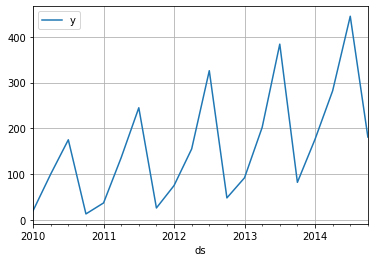

In [ ]:
timeseries.plot(x="ds", y="y");
plt.grid();

En net als in Scikit-Learn moeten we nu een Prophet model instantiëren en dan de `fit` methode aanroepen op het object:

In [ ]:
model = Prophet()
model.fit(timeseries)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesv7lf07/8b_j1b8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesv7lf07/e0ryvlq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71131', 'data', 'file=/tmp/tmpesv7lf07/8b_j1b8y.json', 'init=/tmp/tmpesv7lf07/e0ryvlq3.json', 'output', 'file=/tmp/tmpesv7lf07/prophet_model30l3yvhd/prophet_model-20221204130840.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

We creëren een nieuw `DataFrame` met de `future` tijdstippen:

In [ ]:
future = pd.DataFrame(data=dict(ds=future))

En nu kunnen we net als in Scikit-Learn de `predict` methode gebruiken om de voorspellingen te berekenen:

In [ ]:
forecast = model.predict(future)

En die voorspellingen kunnen we visualiseren met de methode `plot`:

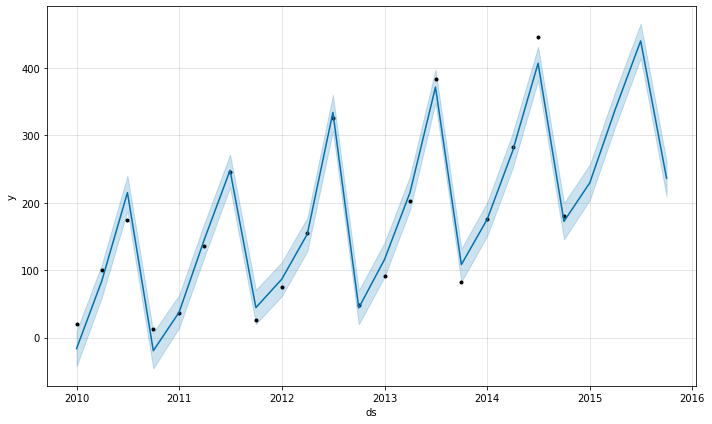

In [ ]:
fig1 = model.plot(forecast)

En we kunnen ook de trend en het seizoenale patroon plotten:

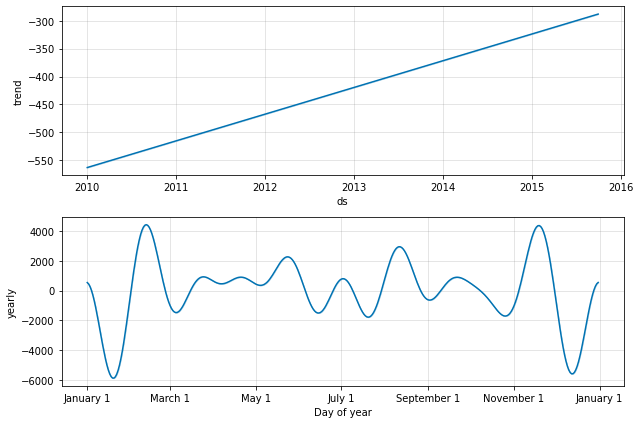

In [ ]:
fig2 = model.plot_components(forecast)

De forecasts zitten in kolom `"yhat"` van het `forecast` DataFrame. Zo kunnen we de metrieken berekenen:

In [ ]:
f = forecast['yhat'].values
m = 4
print("MAE = ", MAE(ts, f[:-m]))
print("RMSE = ", RMSE(ts, f[:-m]))

MAE =  15.526728886761012
RMSE =  20.05552404619459


MAE en RMSE zijn beter dan die van ons multiplicatief model. MAPE hebben we niet berekend omdat we met negatieve voorspellingen zitten.

---
## Bronnen

Deze notebook is grotendeels gebaseerd op het hoofdstuk "Forecasting" van het vak "Data Science I" dat gegeven werd aan de opleiding voor de microdegree "Data Science & Artificial Intelligence" aan de Karel De Grote Hogeschool te Antwerpen in het academiejaar 2019-2020. Het hoofdstuk werd opgesteld door Kris Demuynck in 2018.

Andere bronnen die werden geraadpleegd:
- Hyndman, R.J. & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp2/
- Taylor, S.J. & Letham, B. (2017) Forecasting at scale. PeerJ Preprints 5:e3190v2. https://doi.org/10.7287/peerj.preprints.3190v2
- Chollet, F. (2021) Deep Learning with Python, Second Edition, Manning, Shelter Island, NY.
- https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
- https://www.datapred.com/blog/the-basics-of-backtesting
- https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split.
- https://facebook.github.io/prophet/docs/quick_start.html
- https://www.statology.org/autocorrelation-python/
- https://www.statsmodels.org/stable/tsa.html
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://aishwaryagulve97.medium.com/everything-about-components-of-time-series-part-1-7476fb521477

---